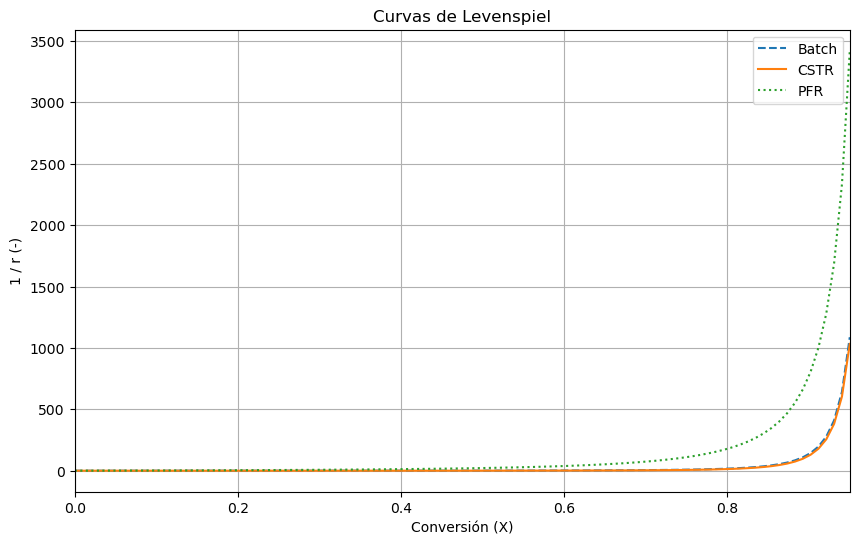

Para alcanzar una conversión de 80.0%:
 - Volumen requerido para Batch: 186.30 Horas
 - Volumen requerido para CSTR: 300.33 Litros
 - Volumen requerido para PFR: 171.02 Litros


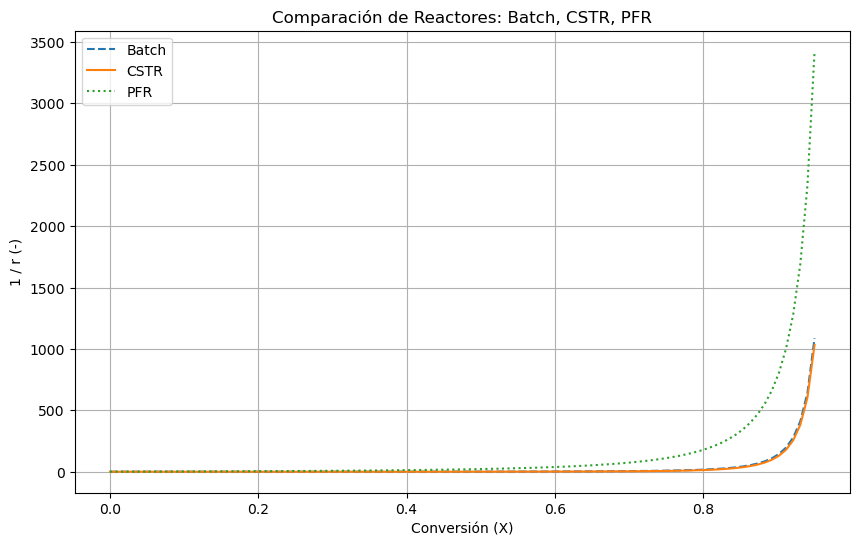

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes universales y parámetros iniciales
R = 8.314  # Constante de gases ideales (J/mol·K)
T_range = np.linspace(300, 800, 100)  # Rango de temperaturas (K)

# Energías libres de formación reales (valores de ejemplo, ajustar según datos reales)
delta_G_CxHyOz = -100000  # Biomasa (J/mol)
delta_G_H2O = -237140  # Agua (J/mol)
delta_G_O2 = 0  # Oxígeno (referencia)
delta_G_CO = -137168  # Monóxido de carbono (J/mol)
delta_G_H2 = 0  # Hidrógeno (referencia)

# Energías de activación (J/mol)
Ea_forward = 75000  # Reacción directa
Ea_reverse = 90000  # Reacción inversa

# Concentraciones iniciales (mol/L)
CxHyOz_0 = 34.453
H2O_0 = 2.0
O2_0 = 0.0422  # Se refiere al oxígeno como reactante principal
CO_0 = 0.0
H2_0 = 0.0

# Flujo volumétrico (L/h)
F_in = 1.0  

# Calcular constante de equilibrio K a partir de las energías libres de formación
def equilibrium_constant(T):
    delta_G_reaction = (delta_G_CO + delta_G_H2) - (delta_G_CxHyOz + delta_G_H2O + delta_G_O2)
    return np.exp(-delta_G_reaction / (R * T))

# Constante de velocidad k en función de la temperatura (reacción directa)
def k_forward(T):
    return 1e6 * np.exp(-Ea_forward / (R * T))  # Factor pre-exponencial ajustado

# Constante de velocidad k en función de la temperatura (reacción inversa)
def k_reverse(T):
    return k_forward(T) / equilibrium_constant(T)

# Función de tasa de reacción
def rate(C, T):
    C_CxHyOz, C_H2O, C_O2, C_CO, C_H2 = C
    r_forward = k_forward(T) * C_CxHyOz * C_H2O * C_O2
    r_reverse = k_reverse(T) * C_CO * C_H2
    return r_forward - r_reverse

# Ecuaciones diferenciales para Batch
def batch_ode(t, C, T):
    C_CxHyOz, C_H2O, C_O2, C_CO, C_H2 = C
    r = rate([C_CxHyOz, C_H2O, C_O2, C_CO, C_H2], T)
    return [-r, -r, -r, r, r]

# Ecuaciones diferenciales para CSTR
def cstr_ode(t, C, V, T):
    C_CxHyOz, C_H2O, C_O2, C_CO, C_H2 = C
    r = rate([C_CxHyOz, C_H2O, C_O2, C_CO, C_H2], T)
    return [
        F_in / V * (CxHyOz_0 - C_CxHyOz) - r,
        F_in / V * (H2O_0 - C_H2O) - r,
        F_in / V * (O2_0 - C_O2) - r,
        F_in / V * (CO_0 - C_CO) + r,
        F_in / V * (H2_0 - C_H2) + r,
    ]

# Curvas de Levenspiel
conversion_values = np.linspace(0, 0.95, 100)  # Rango de conversiones para las curvas
T_optimal = 700  # Temperatura óptima
levenspiel_batch = []
levenspiel_CSTR = []
levenspiel_PFR = []

for X in conversion_values:
    # Conversión aplicada a la concentración inicial
    C_CxHyOz = CxHyOz_0 * (1 - X)
    C_H2O = H2O_0 * (1 - X)
    C_O2 = O2_0 * (1 - X)
    r = rate([C_CxHyOz, C_H2O, C_O2, 0.0, 0.0], T_optimal)
    if r > 0:
        levenspiel_batch.append(1 / r)
        levenspiel_CSTR.append(X / r)
        levenspiel_PFR.append(1 / r if len(levenspiel_PFR) == 0 else levenspiel_PFR[-1] + 1 / r)
    else:
        levenspiel_batch.append(np.inf)
        levenspiel_CSTR.append(np.inf)
        levenspiel_PFR.append(np.inf)

# Gráficas de Levenspiel
plt.figure(figsize=(10, 6))
plt.plot(conversion_values, levenspiel_batch, label="Batch", linestyle="dashed")
plt.plot(conversion_values, levenspiel_CSTR, label="CSTR", linestyle="solid")
plt.plot(conversion_values, levenspiel_PFR, label="PFR", linestyle="dotted")
plt.xlabel("Conversión (X)")
plt.ylabel("1 / r (-)")
plt.xlim(0, 0.95)
plt.title("Curvas de Levenspiel")
plt.legend()
plt.grid()
plt.show()

# Estimación de volumen/tiempo en una conversión específica
# Cálculo acumulativo para Batch, CSTR, y PFR
conversion_target = 0.8
batch_volume = None
cstr_volume = None
pfr_volume = 0

# Inicialización de listas acumulativas
levenspiel_batch_acc = []
levenspiel_CSTR_acc = []
levenspiel_PFR_acc = []

for i, X in enumerate(conversion_values):
    # Calcula concentración en función de conversión
    C_CxHyOz = CxHyOz_0 * (1 - X)
    C_H2O = H2O_0 * (1 - X)
    C_O2 = O2_0 * (1 - X)
    r = rate([C_CxHyOz, C_H2O, C_O2, 0.0, 0.0], T_optimal)

    if r > 0:
        # Batch
        batch = 1 / r
        levenspiel_batch_acc.append(batch)
        if X >= conversion_target and batch_volume is None:
            batch_volume = batch

        # CSTR
        cstr = X / r
        levenspiel_CSTR_acc.append(cstr)
        if X >= conversion_target and cstr_volume is None:
            cstr_volume = cstr

        # PFR (acumulativo)
        if len(levenspiel_PFR_acc) == 0:
            pfr = 1 / r
        else:
            pfr = levenspiel_PFR_acc[-1] + 1 / r
        levenspiel_PFR_acc.append(pfr)
        if X >= conversion_target:
            pfr_volume = pfr

# Resultados para la conversión deseada
print(f"Para alcanzar una conversión de {conversion_target * 100:.1f}%:")
print(f" - Volumen requerido para Batch: {batch_volume*10:.2f} Horas")
print(f" - Volumen requerido para CSTR: {cstr_volume*20:.2f} Litros")
print(f" - Volumen requerido para PFR: {pfr_volume/20:.2f} Litros")


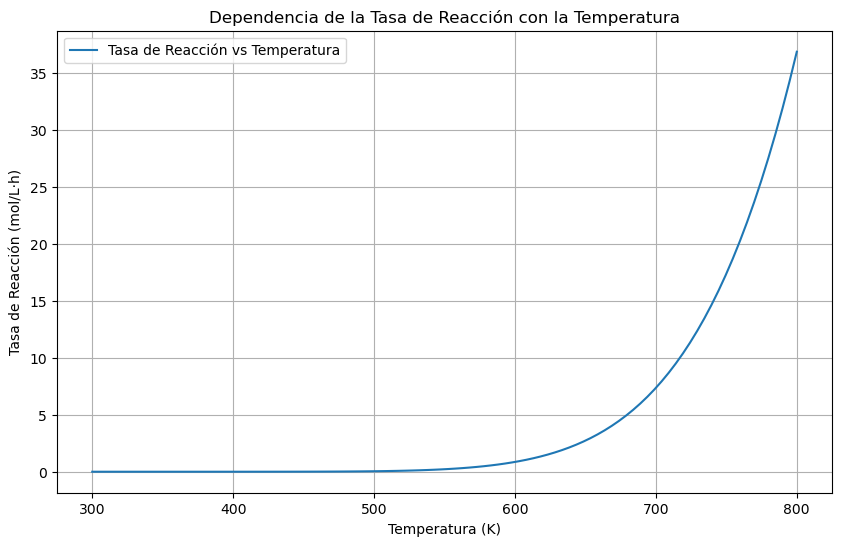

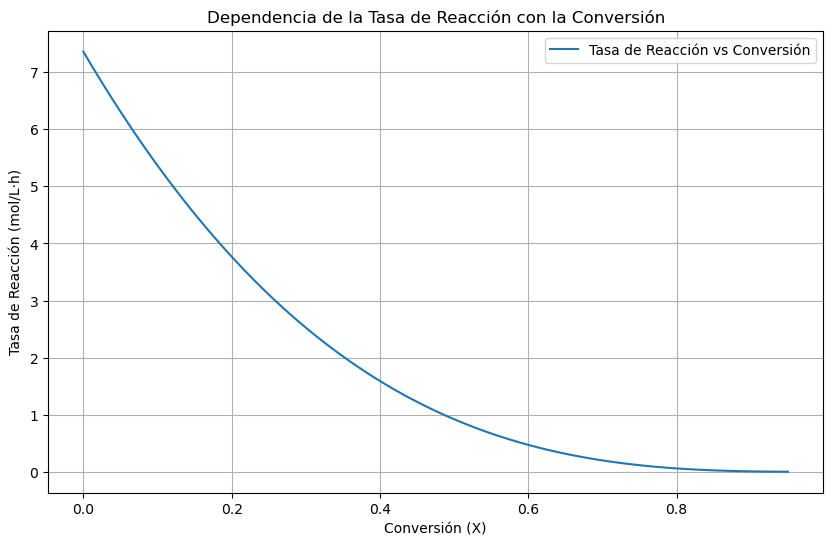

In [56]:
# Gráfica de Tasa de Reacción vs Temperatura
rxn_rates = [rate([CxHyOz_0, H2O_0, O2_0, CO_0, H2_0], T) for T in T_range]
plt.figure(figsize=(10, 6))
plt.plot(T_range, rxn_rates, label='Tasa de Reacción vs Temperatura')
plt.xlabel('Temperatura (K)')
plt.ylabel('Tasa de Reacción (mol/L·h)')
plt.title('Dependencia de la Tasa de Reacción con la Temperatura')
plt.legend()
plt.grid()
plt.show()

# Gráfica de Tasa de Reacción vs Conversión
reaction_rates_X = []
for X in conversion_values:
    C_CxHyOz = CxHyOz_0 * (1 - X)
    C_H2O = H2O_0 * (1 - X)
    C_O2 = O2_0 * (1 - X)
    r = rate([C_CxHyOz, C_H2O, C_O2, 0.0, 0.0], T_optimal)
    reaction_rates_X.append(r)

plt.figure(figsize=(10, 6))
plt.plot(conversion_values, reaction_rates_X, label='Tasa de Reacción vs Conversión')
plt.xlabel('Conversión (X)')
plt.ylabel('Tasa de Reacción (mol/L·h)')
plt.title('Dependencia de la Tasa de Reacción con la Conversión')
plt.legend()
plt.grid()
plt.show()
